# Cusine Recommender at Edge
> Train a simple cusine recommender model, convert into ONNX and wrap into javascript/html to serve at edge

- toc: true
- badges: true
- comments: true
- categories: [Restaurant, ONNX, EdgeModel, Javascript, Netron]
- image:

| |  |
| :-: | -:|
| Vision | Serve recommender models at edge |
| Mission | Train a simple recommender model and wrap into javascript wrapper to serve at edge offline  |
| Scope | Model training, Offline evaluation, Single pre-processed dataset |
| Task | Category prediction |
| Data | Cuisine |
| Tool | Onnx, Netron, Sklearn, Colab, Python |
| Technique | sklearn for model training and skleonnx for model conversion |
| Process | 1) Build a simple content-based cuisine recommender model (formulating the task as a simple classification problem), 2) Convert it into onnx format using skl2onnx, 3) Visualize the model using Netron, 4) Wrap the model in http wrapper, 5) Serve using python http service |
| Takeaway | Serving at edge is important for recommenders in case of privacy concerns and onnx is powerful tool to convert the models |
| Credit | [Microsoft](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/4-Applied/README.md) |

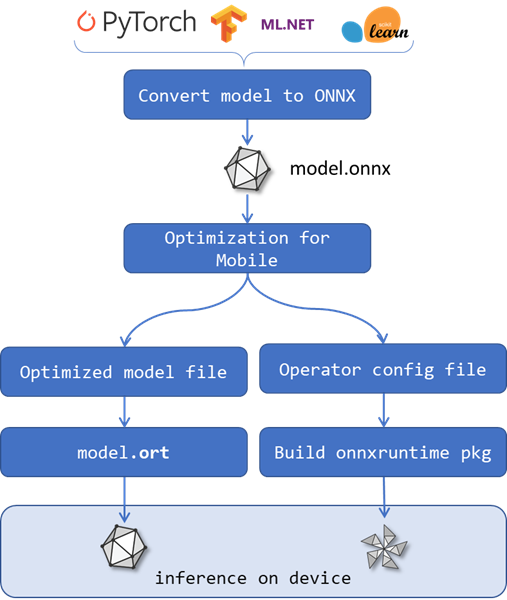

## Setup

In [ ]:
!pip install skl2onnx
!pip install -q netron

In [ ]:
import os
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix,classification_report

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

import netron

import portpicker
from google.colab import output
import threading
from http.server import HTTPServer, CGIHTTPRequestHandler

%matplotlib inline

## Load data

In [ ]:
data = pd.read_csv('https://github.com/microsoft/ML-For-Beginners/raw/main/4-Classification/data/cleaned_cuisine.csv')
data.head()

,Unnamed: 0,cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,artichoke,asparagus,avocado,bacon,baked_potato,balm,banana,barley,bartlett_pear,basil,bay,bean,beech,beef,beef_broth,beef_liver,beer,beet,bell_pepper,bergamot,berry,bitter_orange,black_bean,black_currant,black_mustard_seed_oil,black_pepper,black_raspberry,black_sesame_seed,black_tea,...,sunflower_oil,sweet_potato,swiss_cheese,tabasco_pepper,tamarind,tangerine,tarragon,tea,tequila,thai_pepper,thyme,tomato,tomato_juice,truffle,tuna,turkey,turmeric,turnip,vanilla,veal,vegetable,vegetable_oil,vinegar,violet,walnut,wasabi,watercress,watermelon,wheat,wheat_bread,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,0,indian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,indian,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,indian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,indian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,4,indian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
X = data.iloc[:,2:]
X.head()

,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,artichoke,asparagus,avocado,bacon,baked_potato,balm,banana,barley,bartlett_pear,basil,bay,bean,beech,beef,beef_broth,beef_liver,beer,beet,bell_pepper,bergamot,berry,bitter_orange,black_bean,black_currant,black_mustard_seed_oil,black_pepper,black_raspberry,black_sesame_seed,black_tea,blackberry,blackberry_brandy,...,sunflower_oil,sweet_potato,swiss_cheese,tabasco_pepper,tamarind,tangerine,tarragon,tea,tequila,thai_pepper,thyme,tomato,tomato_juice,truffle,tuna,turkey,turmeric,turnip,vanilla,veal,vegetable,vegetable_oil,vinegar,violet,walnut,wasabi,watercress,watermelon,wheat,wheat_bread,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
y = data[['cuisine']]
y.head()

,cuisine
0,indian
1,indian
2,indian
3,indian
4,indian


## Train the model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [ ]:
model = SVC(kernel='linear', C=10, probability=True,random_state=0)
model.fit(X_train,y_train.values.ravel())

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     chinese       0.68      0.72      0.70       241
      indian       0.90      0.88      0.89       242
    japanese       0.75      0.80      0.78       227
      korean       0.84      0.70      0.77       259
        thai       0.74      0.81      0.77       230

    accuracy                           0.78      1199
   macro avg       0.78      0.78      0.78      1199
weighted avg       0.78      0.78      0.78      1199



## Convert the model to Onnx
Make sure to do the conversion with the proper Tensor number. This dataset has 380 ingredients listed, so you need to notate that number in `FloatTensorType`.

In [ ]:
initial_type = [('float_input', FloatTensorType([None, 380]))]
options = {id(model): {'nocl': True, 'zipmap': False}}
onx = convert_sklearn(model, initial_types=initial_type, options=options)
with open("./model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

## View your model

In [19]:
port = portpicker.pick_unused_port()

# Read the model file and start the netron browser.
with output.temporary():
  netron.start('model.onnx', browse=False, address=port)

output.serve_kernel_port_as_iframe(port, height='800')

<IPython.core.display.Javascript object>

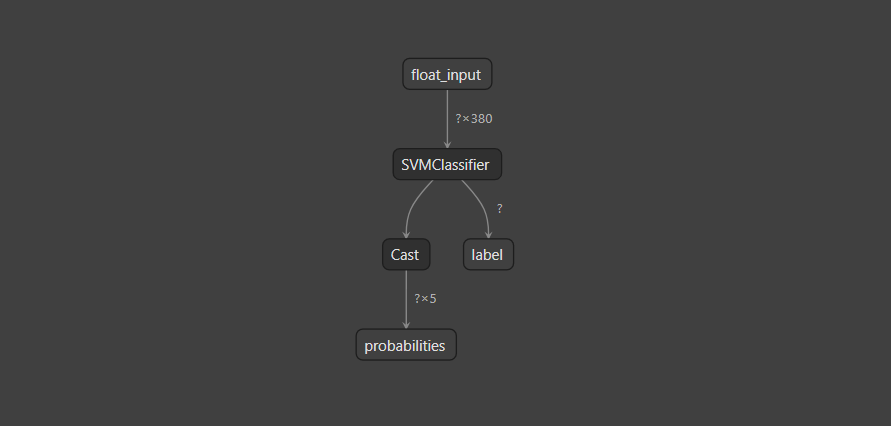

Now you are ready to use this neat model in a web app. Let's build an app that will come in handy when you look in your refrigerator and try to figure out which combination of your leftover ingredients you can use to cook a given cuisine, as determined by your model.

You can use your model directly in a web app. This architecture also allows you to run it locally and even offline if needed. Start by creating an `index.html` file in the same folder where you stored your `model.onnx` file.

## Build a recommender web application

In [20]:
%%writefile index.html
<!DOCTYPE html>
<html>
    <header>
        <title>Cuisine Matcher</title>
    </header>
    <body>
        <h1>Check your refrigerator. What can you create?</h1>
        <div id="wrapper">
            <div class="boxCont">
                <input type="checkbox" value="4" class="checkbox">
                <label>apple</label>
            </div>
        
            <div class="boxCont">
                <input type="checkbox" value="247" class="checkbox">
                <label>pear</label>
            </div>
        
            <div class="boxCont">
                <input type="checkbox" value="77" class="checkbox">
                <label>cherry</label>
            </div>

            <div class="boxCont">
                <input type="checkbox" value="126" class="checkbox">
                <label>fenugreek</label>
            </div>

            <div class="boxCont">
                <input type="checkbox" value="302" class="checkbox">
                <label>sake</label>
            </div>

            <div class="boxCont">
                <input type="checkbox" value="327" class="checkbox">
                <label>soy sauce</label>
            </div>

            <div class="boxCont">
                <input type="checkbox" value="112" class="checkbox">
                <label>cumin</label>
            </div>
        </div>
        <div style="padding-top:10px">
            <button onClick="startInference()">What kind of cuisine can you make?</button>
        </div>      
        <!-- import ONNXRuntime Web from CDN -->
        <script src="https://cdn.jsdelivr.net/npm/onnxruntime-web@1.8.0-dev.20210608.0/dist/ort.min.js"></script>
        <script>
            const ingredients = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            
            const checks = [].slice.call(document.querySelectorAll('.checkbox'));

            // use an async context to call onnxruntime functions.
            function init() {
                
                checks.forEach(function (checkbox, index) {
                    checkbox.onchange = function () {
                        if (this.checked) {
                            var index = checkbox.value;

                            if (index !== -1) {
                                ingredients[index] = 1;
                            }
                            console.log(ingredients)
                        }
                        else {
                            var index = checkbox.value;

                            if (index !== -1) {
                                ingredients[index] = 0;
                            }
                            console.log(ingredients)
                        }
                    }
                })
            }

            function testCheckboxes() {
                    for (var i = 0; i < checks.length; i++)
                        if (checks[i].type == "checkbox")
                            if (checks[i].checked)
                                return true;
                    return false;
            }

            async function startInference() {

                let checked = testCheckboxes()

                if (checked) {

                try {
                    // create a new session and load the model.
                    
                    const session = await ort.InferenceSession.create('./model.onnx');

                    const input = new ort.Tensor(new Float32Array(ingredients), [1, 380]);
                    const feeds = { float_input: input };

                    // feed inputs and run

                    const results = await session.run(feeds);

                    // read from results
                    alert('You can enjoy ' + results.label.data[0] + ' cuisine today!')

                } catch (e) {
                    console.log(`failed to inference ONNX model: ${e}.`);
                }
            }
            else alert("Please check an ingredient")
                
            }
    init();
           
        </script>
    </body>
</html>

Writing index.html


In this code, there are several things happening:

1. You created an array of 380 possible values (1 or 0)  to be  set and sent to the model for inference, depending on whether an ingredient checkbox is checked.
2. You created an array of checkboxes and a way to determine whether they were checked in an `init` function that is called when the application starts. When a checkbox is checked, the `ingredients` array is altered to reflect the chosen ingredient.
3. You created a `testCheckboxes` function that checks whether any checkbox was checked.
4. You use that function when the button is pressed and, if any checkbox is checked, you start inference.
5. The inference routine includes:
   1. Setting up an asynchronous load of the model
   2. Creating a Tensor structure to send to the model
   3. Creating 'feeds' that reflects the `float_input` input that you created when training your model (you can use Netron to verify that name)
   4. Sending these 'feeds' to the model and waiting for a response

Notice that each checkbox is given a value. This reflects the index where the ingredient is found according to the dataset. Apple, for example, in this alphabetic list, occupies the fifth column, so its value is '4' since we start counting at 0. You can consult the ingredients dictionary `ingdt2idx` to discover a given ingredient's index.

In [29]:
idx2ingdt = {k:v for k,v in enumerate(X.columns)}
ingdt2idx = {v:k for k,v in list(idx2ingdt.items())}
ingdt2idx['avocado']

11

## Serve the model

In [47]:
port = portpicker.pick_unused_port()
myserver = HTTPServer(server_address=('', port), RequestHandlerClass=CGIHTTPRequestHandler)

def start_server():
    myserver.serve_forever()

thread = threading.Thread(target=start_server)
thread.start()

output.serve_kernel_port_as_iframe(port)

<IPython.core.display.Javascript object>

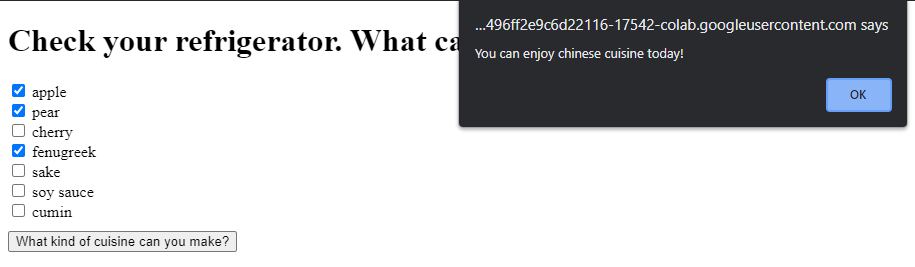

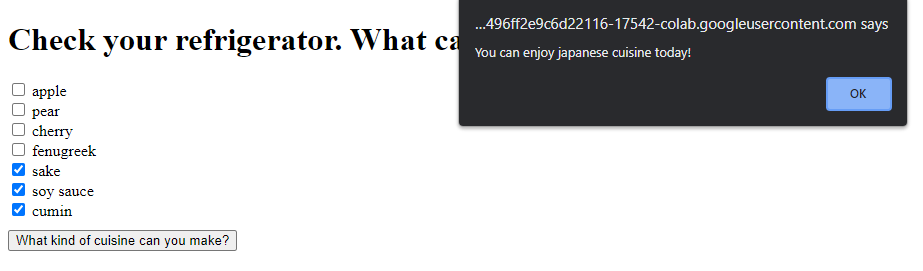